In [15]:
#Outline

#Batch process everything
#Don't use bass.py file

#Data Analysis
# peakutil baseline
# SG Filter
# Peak Detect
# Burst Detect

#Output
# Breaths
# Recording Length (s)
# Mean Breath Rate
# Minute Ventilation
# AUC
# AUC STD
# Insp Time mean
# Insp Time std
# Exp Time mean
# Exp Time std
# TTotal Time mean
# TTotal Time std
# Apnea Count
# TI Sample Entropy
# TE Sample Entropy
# TTot Sample Entropy
# TI Shannon Entropy
# TE Shannon Entropy
# TTot Shannon Entropy
# Poincare SD 1 Total Cycle time
# Poincare SD 2 Total Cycle time
# Poincare SD1/SD2 Ratio Total Cycle Time
# Poincare SD 1 Burst Duration
# Poincare SD 2 Burst Duration
# Poincare SD1/SD2 Ratio Total Cycle Time
# Poincare SD 1 Interburst Interval
# Poincare SD 2 Interburst Interval
# Poincare SD1/SD2 Ratio Interburst Interval
# Poincare Plots (y = SD1, x = SD2) with ellipses

Import Modules

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import signal, optimize
import peakutils
from peakutils.plot import plot as pplot
from pyentrp import entropy as ent

Load File

In [17]:
filename = '10-23-17-18_MYD88_SHAM-hypoxia'

df = pd.read_csv('C:\Users\John\Dropbox\Exported\\' + filename + '.txt',
                 sep = '\t', names = ["Time", "Data"], index_col='Time')

In [18]:
df = df.iloc[2000:10000] #slice the data
#delete this code block when you want to run the whole file

Plot Data

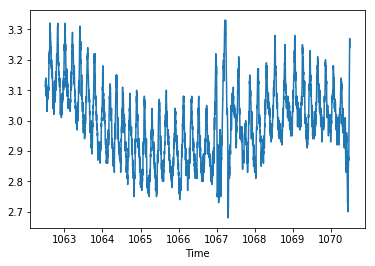

In [19]:
df['Data'].plot()

Detrend baseline using an iterative polynomial regression algorithm
- polynomial is set to 6, can be changed

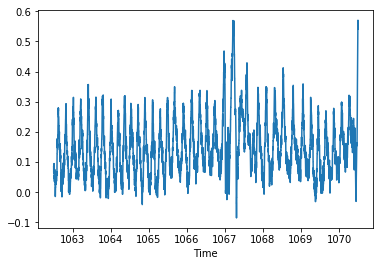

In [20]:
#http://peakutils.readthedocs.io/en/latest/tutorial_a.html
#http://peakutils.readthedocs.io/en/latest/reference.html#module-peakutils.baseline
df['peakutils'] = peakutils.baseline(df['Data'], 6) #polynomial = 6, can change
df['Detrend'] = df['Data']-df['peakutils']
df['Detrend'].plot()

Savitzky-Golay Filter
- window must be odd
- polyorder is an integer

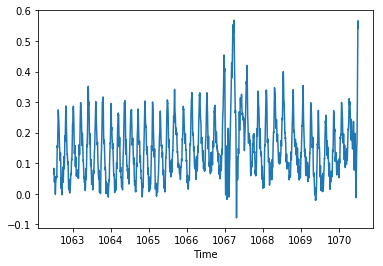

In [21]:
window = 31
polyorder = 6
df['SG_Filter'] = signal.savgol_filter(df['Detrend'], window, polyorder)
df['SG_Filter'].plot()

Peak Detection
- Uses peakutils module
- Normalized threshold between 0-100
- min_dist is delta

68


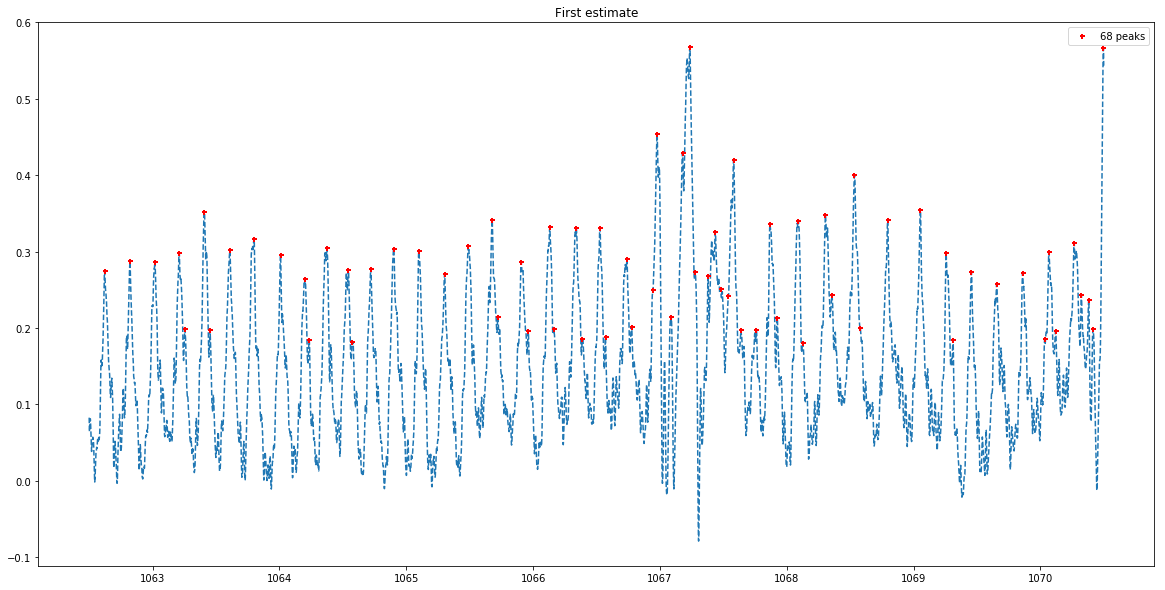

In [22]:
#thres (float between [0., 1.]) – Normalized threshold. Only the peaks with amplitude higher than the threshold will be detected.
#min_dist (int) – Minimum distance between each detected peak. The peak with the highest amplitude is preferred to satisfy this constraint.

x = df.index
y = df['SG_Filter'].values
thresh = .4
min_dist = 30

indexes = peakutils.indexes(y, thresh, min_dist)
print len(indexes)

plt.figure(figsize=(20,10))
pplot(x, y, indexes)
plt.title('First estimate')
plt.show()

Calculate Bursts
- modified from bass.py
- added normalized threshold value

In [23]:
def burstcalc(dataframe, thresh, clustertime=0, burstmin = 0, burstmax=100000):
    
    time = dataframe.index
    data = dataframe.values
    
    burst_start = [] #empty array for burst start
    burst_end = [] #empty array for burst end
    burst_duration = [] #empty array to calculate burst durration
    
    thresh *= np.max(y) - np.min(y)
    #normalized threshold between 0 and 1
    
    burst = False #burst flag, should start not in a burst

    index = -1
    for point in data: #for each data point in the set
        index = index +1
        #print index, "=", t.clock()
        
        if burst == False and point > thresh: #if we are not in a burst already, the value is higher than the threshold, 
            #   AND the last burst didn't end less than .2 ms ago
            #   .2 ms WHERE???? maybe from rat_ECG.txt test data file?
            tpoint = time[index] #find the actual time given the time index
            burst_start.append(tpoint) #add the time at point as the begining of the burst
            burst = True #burst flag, we are now in a burst 
        
        if burst == True and  point <= thresh: #if we are in a burst and the point falls below the threshold
            
            if len(burst_end) == 0 or len(burst_start) == 0: #if this is the first end
                tpoint = time[index] #find the actual time given teh time index
                burst_end.append (tpoint) #add the time at point as the end of the burst
                burst = False #burst flag, we are now out of the burst
            
            else:
                tpoint = time[index] #find the actual time given teh time index
                burst_end.append (tpoint) #add the time at point as the end of the burst
                burst = False #burst flag, we are now out of the burst
                if burst_start[-1] < (burst_end[-2] + clustertime):#if the new burst is too close to the last one, delete the second to last end and the last start
                    del burst_end[-2]
                    del burst_start[-1]
    
    if burst == True and len(burst_start) == 1+len(burst_end): #we exit the for loop but are in a burst
        #del burst_start[-1] #delete the last burst start time
        burst_end.append(time[-1]) #last time point is the end of burst
    if len(burst_start) != len(burst_end):
        raise Exception('Unexpectedly, the number of burst start times and end times are not equal. Seeing as this is physically impossible, I quit the program for you. Begin hunting for the fatal flaw. Good luck!')
        
    #print t.clock(), "- start duration array"
    for foo in burst_start: #for each burst
        index = burst_start.index(foo)
        duration = burst_end[index] - burst_start[index] #calculate duration by subtracting the start time from the end time, found by indexing
        burst_duration.append(duration) #add the burst duration to the duration list
    #print t.clock(), "-end duration array"
    
    #return burst_start, burst_end, burst_duration
    
    #Burst Calc into DataFrame
    results_bursts = pd.DataFrame({'Burst Start': burst_start})
    results_bursts.index = np.arange(len(burst_start))
    results_bursts['Burst End'] = burst_end
    results_bursts['Burst Duration'] = burst_duration
    
    results_bursts = results_bursts[results_bursts['Burst Duration']>burstmin]
    results_bursts = results_bursts[results_bursts['Burst Duration']<=burstmax]
    
    return results_bursts #dataframe

In [24]:
#calculate results_bursts
results_bursts = burstcalc(df['SG_Filter'], thresh, .05, burstmin = 0, burstmax=100000)

Experimenting with an optimized sine curve fit - has no bearing on data calculation, only visualization

In [25]:
#https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
#use fft to find the optimal sine fit for your data
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
    
    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    res = {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}
    return tt, res["fitfunc"](tt) #x and y

In [26]:
def burstgraph(dataframe, indexes):        
   
    results_bursts = burstcalc(dataframe, thresh, clustertime=.05, burstmin = 0, burstmax=20)

    x = dataframe.index
    y = dataframe.values

    plt.figure(figsize=(20,10))

    #plot data and peaks, same as peakgraph function
    plt.plot(dataframe.index, dataframe.values)
    plt.plot(x[indexes], y[indexes], 
         marker = '^', color = 'r', linestyle = 'None', alpha = 1, label = 'Peak', markersize = 5)

    #fit to a sine wave only for visuzalization purposes (no calculation is done)
    x_new, y_new = fit_sin(x, y)

    plt.plot(x_new, y_new)

    temp_df = pd.DataFrame()
    temp_df['x_new'] = x_new
    temp_df['y_new'] = y_new
    temp_df['Burst Start'] = results_bursts['Burst Start'] 
    temp_df['Burst End'] = results_bursts['Burst End'] 

    #plot bursts along polynomial fit line
    plt.plot(temp_df.loc[temp_df['x_new'].isin(results_bursts['Burst Start'])]['x_new'],
        temp_df.loc[temp_df['x_new'].isin(results_bursts['Burst Start'])]['y_new'],
        marker = 's', color = 'g', linestyle = 'None', alpha = 1, label = 'Burst Start', markersize = 5)
    plt.plot(temp_df.loc[temp_df['x_new'].isin(results_bursts['Burst End'])]['x_new'],
        temp_df.loc[temp_df['x_new'].isin(results_bursts['Burst End'])]['y_new'],
        marker = 's', color = 'y', linestyle = 'None', alpha = 1, label = 'Burst End', markersize = 5)

    plt.show()
    return results_bursts

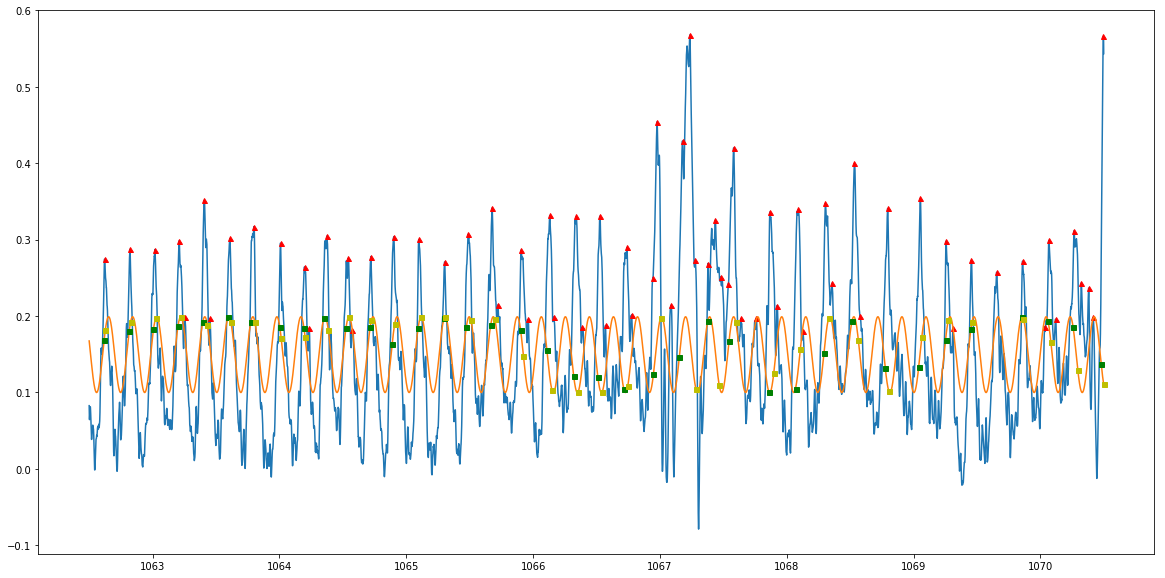

In [27]:
results_bursts = burstgraph(df['SG_Filter'], indexes)

Burst Area calculation
- using trapezoidal rule

In [28]:
def burstarea(dataframe, results_bursts, dx = 1):
    
    data = dataframe.values
    time = dataframe.index
    burst_start = results_bursts['Burst Start'].values
    burst_end = results_bursts['Burst End'].values
    
    """
    integral, area under curve of each burst. Use start and end times to split the y values into short lists. 
    need the time array to do this
    """
    from scipy.integrate import simps, trapz #import the integral functions
    
    time = list(time) #time array must be a list for the indexting to work.
    
    burst_area = [] #empty array for the areas to go into
    #count = 0
    for i in np.arange(len(burst_start)): #for each index in the start array
        end = time.index(burst_end[i]) #using the value at each i in the burst_end array, index in the time array to get the time index. this will be the same index # as the data array
        start = time.index(burst_start[i])
        area = trapz(data[start:end], x=time[start:end], dx= dx) #find area using the trapz function, but only 
        burst_area.append(area)
 
    return burst_area

In [29]:
burst_area = burstarea(df['SG_Filter'], results_bursts)

Interburst Interval

In [30]:
def interburstinterval(burst_start, burst_end):
    
    ibi = []
    
    for i in np.arange(0, len(burst_start)-1):
        ibi.append(burst_start[i+1] - burst_end[i])
        
    return ibi

Poincare functions

In [31]:
def poincare(array):
    #calculate SD1 and SD2
    #definitions obtained from http://www.if.uz.zgora.pl/~jaropis/geomasy.pdf, modified from bass code
    
    df = pd.DataFrame(array)
    data = df.dropna()
    data = data[0].values
    
    x = data[:-1]
    y = data[1:]
    
    xc = np.mean(x)
    yc = np.mean(y)  
    
    SD1 = 0
    SD2 = 0
    
    for i in np.arange(len(x)):
        
        d1 = np.power(abs((x[i]-xc)-(y[i]-yc))/np.sqrt(2), 2)
        SD1 = SD1 + d1
        
        d2 = np.power(abs((x[i]-xc)+(y[i]-yc))/np.sqrt(2), 2)
        SD2 = SD2 + d2
    
    SD1 = np.sqrt(SD1/len(x))
    SD2 = np.sqrt(SD2/len(x))
    
    return x, y, xc, yc, SD1, SD2 

def poincare_plot(data, label):
    #function to plot
    x, y, xc, yc, SD1, SD2 = poincare(data)
    
    center = xc, yc
    
    ax = plt.subplot(111, aspect = "equal")
    
    plt.plot(center[0], center[1], color="r", marker= "+")

    y1 = x
    y2 = y
    
    ellipse = patches.Ellipse(center, width = SD2, height = SD1, angle = 45, fill = False, color = "r")

    ax.set_xlabel("y(t)")
    ax.set_ylabel("y(t + 1)")
    ax.scatter(y1, y2, color = 'k', marker = '.')
    ax.add_patch(ellipse)
    

    plt.title('Poincare Plot ' + label) #-%s' %series.name)
    
    
    plt.show()
    
    return SD1, SD2

Calculate everything and put it in one dataframe

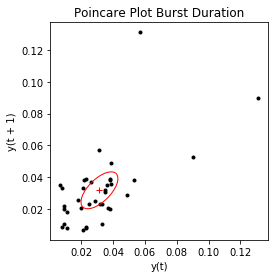

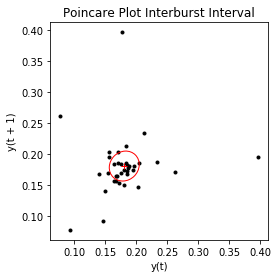

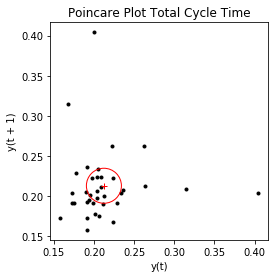

In [32]:
Results = pd.DataFrame(index=[filename])

#Breaths
# Calculated by counting the number of bursts
Results['Breaths'] = results_bursts['Burst Start'].count()

#Recording Length (s)
# Last time index - first time index.
Results['Recording Length (s)'] = df.index[-1]-df.index[0]

#Mean Breath Rate (breaths per minute)
# Breaths divided by minutes
Results['Mean Breath Rate'] = Results['Breaths']/(Results['Recording Length (s)']/60)

#Minute Ventilation
# Average of all the peak amplitudes (tidal volume) * mean breath rate (respiratory rate)
Results['Minute Ventilation'] = np.mean(y[indexes]) * Results['Mean Breath Rate']

#AUC
# Mean of Burst Area
# Std Deviation of Burst Area
Results['AUC Mean'] = np.nanmean(burst_area)
Results['AUC Std'] = np.nanstd(burst_area)

#Insp Time
# Mean of Burst Duration
# Std Deviation of Burst Duration
bd = results_bursts['Burst Duration'].dropna()
bd = bd.values
Results['Insp Time Mean'] = np.nanmean(bd)
Results['Insp Time Std'] = np.nanstd(bd)

#Exp Time
# Mean of Interburst Intervals
# Std Deviation of Interburst Intervals
ibi = interburstinterval(results_bursts['Burst Start'].values, results_bursts['Burst End'].values)
ibi = np.asarray(ibi)
Results['Exp Time Mean'] = np.nanmean(ibi)
Results['Exp Time Std'] = np.nanstd(ibi)

#TTotal Time
# Mean of Total Cycle Time
# Std Deviation of Total Cycle Time
tct = np.diff(results_bursts['Burst Start'])
Results['TTotal Mean'] = np.nanmean(tct)
Results['TTotal Std'] = np.nanstd(tct)

#Apnea Count
# Calculate Apnea Threshold
#    Set Apnea Index as the Mean Difference of Total Cycle times
#    Definition of Apnea: 3 * the Apnea Index
# Count Apneas
#    If length of time between Burst Starts is > Apnea Threshold, add a count
apnea_index = np.nanmean(tct)
apnea_thresh = 3 * apnea_index
apnea_count = list((tct > apnea_thresh)).count(True)

#Sample Entropy
# https://github.com/nikdon/pyEntropy
# TI = Burst Duration
# TE = IBI
# TTotal = Total Cycle Time


Results['SampEn TI'] = ent.sample_entropy(bd, 2, 0.2*np.std(bd))[0]
Results['SampEn TE'] = ent.sample_entropy(ibi, 2, 0.2*np.std(ibi))[0]
Results['SampEn TTotal'] = ent.sample_entropy(tct, 2, 0.2*np.std(tct))[0]

#Shannon Entropy
# https://github.com/nikdon/pyEntropy
# TI = Burst Duration
# TE = IBI
# TTotal = Total Cycle Time
# Drop NA values
Results['ShanEn TI'] = ent.shannon_entropy(bd)
Results['ShanEn TE'] = ent.shannon_entropy(ibi)
Results['ShanEn TTotal'] = ent.shannon_entropy(tct)

#Poincare Plots
# Functions modified from bass.py
#    http://logika.uwb.edu.pl/studies/download.php?volid=48&artid=ka

bd_sd1, bd_sd2 = poincare_plot(bd, 'Burst Duration')
ibi_sd1, ibi_sd2 = poincare_plot(ibi, 'Interburst Interval')
tct_sd1, tct_sd2 = poincare_plot(tct, 'Total Cycle Time')

Results['Poincare SD1 Burst Duration'] = bd_sd1
Results['Poincare SD2 Burst Duration'] = bd_sd2
Results['Poincare SD1/SD2 Burst Duration'] = bd_sd1/bd_sd2

Results['Poincare SD1 Interburst Interval'] = ibi_sd1
Results['Poincare SD2 Interburst Interval'] = ibi_sd2
Results['Poincare SD1/SD2 Interburst Interval'] = ibi_sd1/ibi_sd2

Results['Poincare SD1 Total Cycle Time'] = tct_sd1
Results['Poincare SD2 Total Cycle Time'] = tct_sd2
Results['Poincare SD1/SD2 Total Cycle Time'] = tct_sd1/tct_sd2


In [33]:
Results

,Breaths,Recording Length (s),Mean Breath Rate,Minute Ventilation,AUC Mean,AUC Std,Insp Time Mean,Insp Time Std,Exp Time Mean,Exp Time Std,...,ShanEn TTotal,Poincare SD1 Burst Duration,Poincare SD2 Burst Duration,Poincare SD1/SD2 Burst Duration,Poincare SD1 Interburst Interval,Poincare SD2 Interburst Interval,Poincare SD1/SD2 Interburst Interval,Poincare SD1 Total Cycle Time,Poincare SD2 Total Cycle Time,Poincare SD1/SD2 Total Cycle Time
10-23-17-18_MYD88_SHAM-hypoxia,38,7.999,285.035629,80.199135,0.00959,0.009048,0.031237,0.023042,0.180919,0.047581,...,4.885129,0.013972,0.029633,0.471503,0.045685,0.05064,0.902152,0.043663,0.043613,1.001139


In [ ]:
#To-Do
#Stratify datasets by error type and apply different filtering/detrending, peak detect and burst detect settings for each er